In [1]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from scipy import stats

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *

from MasterPlot_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   
cmap = mpl.colormaps['cmr.seaweed']  

In [2]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [3]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [4]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present'].copy()
future=df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

#### Change data

In [5]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur.csv")

#### Seasonal splits

In [6]:
df_changes_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_byduration_summer = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

df_changes_winter = df_changes_all_season[df_changes_all_season['season']=='Winter']
df_changes_byduration_winter = df_changes_byduration_season[df_changes_byduration_season['season']=='Winter']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

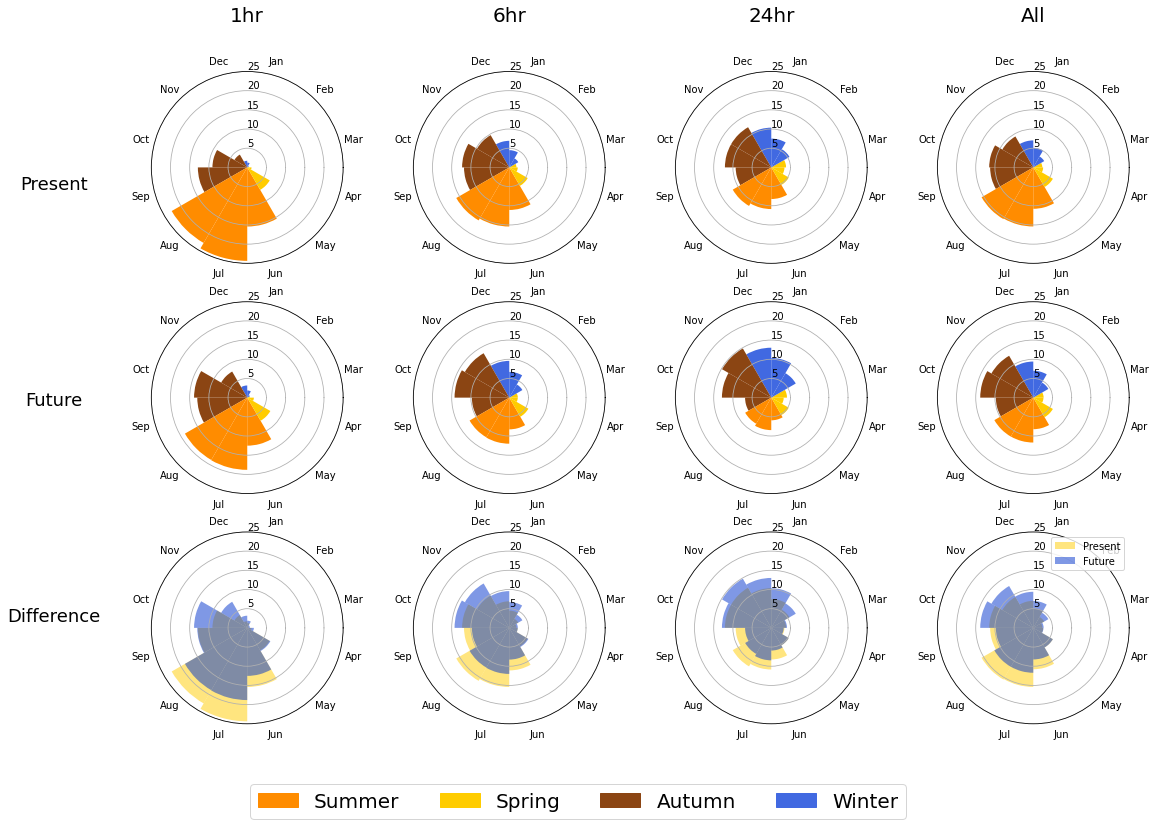

In [7]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'polar': True})

# # Loop through durations, axes, and titles
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(present, axes[0, 3], True, "All",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(future, axes[1,3], False, "Present (all)",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');


# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration_pres = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present, future, axes[2, 3], False, 'All', True, 25) 
fig.text(0.06, 0.25, 'Difference', va='center', ha='center', fontsize=18, rotation='horizontal');

import matplotlib.patches as mpatches
winter_patch = mpatches.Patch(color='royalblue', label='Winter')
autumn_patch = mpatches.Patch(color='#8b4513', label='Autumn')
spring_patch = mpatches.Patch(color='#ffcc00', label='Spring')
summer_patch = mpatches.Patch(color='#ff8c00', label='Summer')

fig.legend(handles=[summer_patch, spring_patch, autumn_patch, winter_patch], loc = 'lower center',
           fontsize=20, ncol=4);

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Histogram of the days of year for 24h, before 

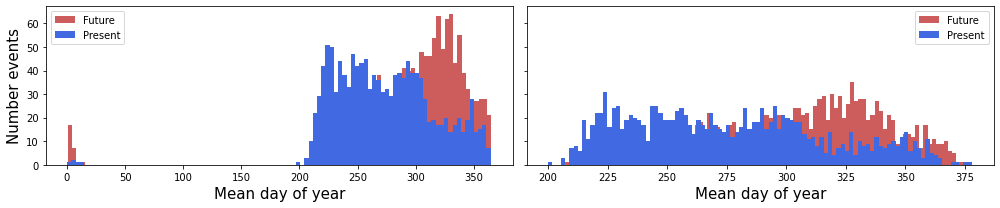

In [8]:
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)].copy()

fig, axs = plt.subplots(ncols=2, figsize=(14, 3), sharey=True)
axs[0].hist(this_duration['D_mean_future'],bins=100, label='Future', color = 'IndianRed')
axs[0].hist(this_duration['D_mean_present'], bins=100, label='Present', color='RoyalBlue')
axs[0].legend()
axs[0].set_xlabel('Mean day of year', fontsize=15)

this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
this_duration["D_mean_future"]= this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)

axs[1].hist(this_duration['D_mean_future'],bins=100, label='Future', color = 'IndianRed')
axs[1].hist(this_duration['D_mean_present'], bins=100, label='Present', color='RoyalBlue')
axs[1].legend()
axs[1].set_xlabel('Mean day of year', fontsize=15)
axs[0].set_ylabel('Number events', fontsize=15)

plt.tight_layout()

### Day of year - present, future, change

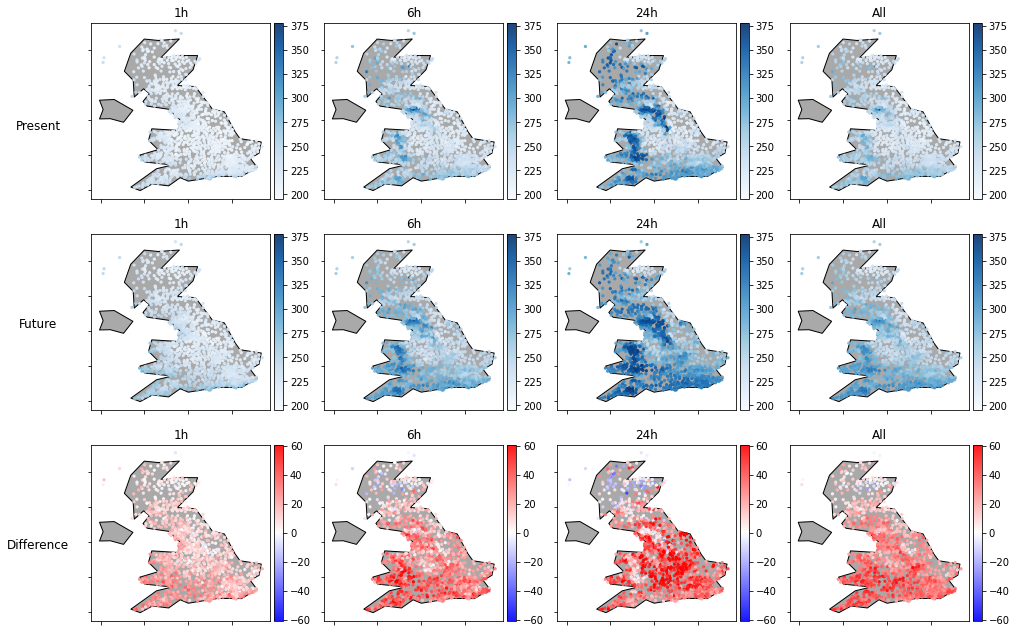

In [9]:
make_plot_D(df_changes_all, df_changes_byduration, 'D_mean','Blues' )

###  R (how dispersed events are) - present, future change

-0.2526397465769423
0.2526397465769423


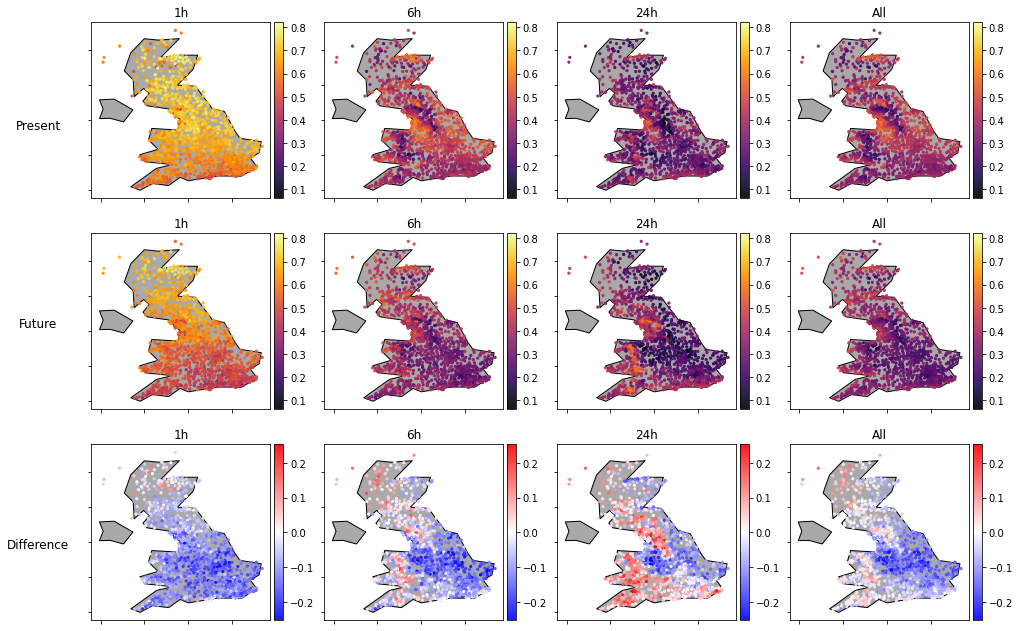

In [10]:
make_plot(df_changes_all, df_changes_byduration, 'R', 'inferno')

# Loading analysis

In [11]:
# make_plot(df_changes_all, df_changes_byduration, 'D50_P90', 'RdYlGn') # PiYG #PuBuGn
# make_plot(df_changes_all, df_changes_byduration, 'D50_P10', 'RdYlGn_R') # PiYG #PuBuGn

-4.593444436124322
4.593444436124322


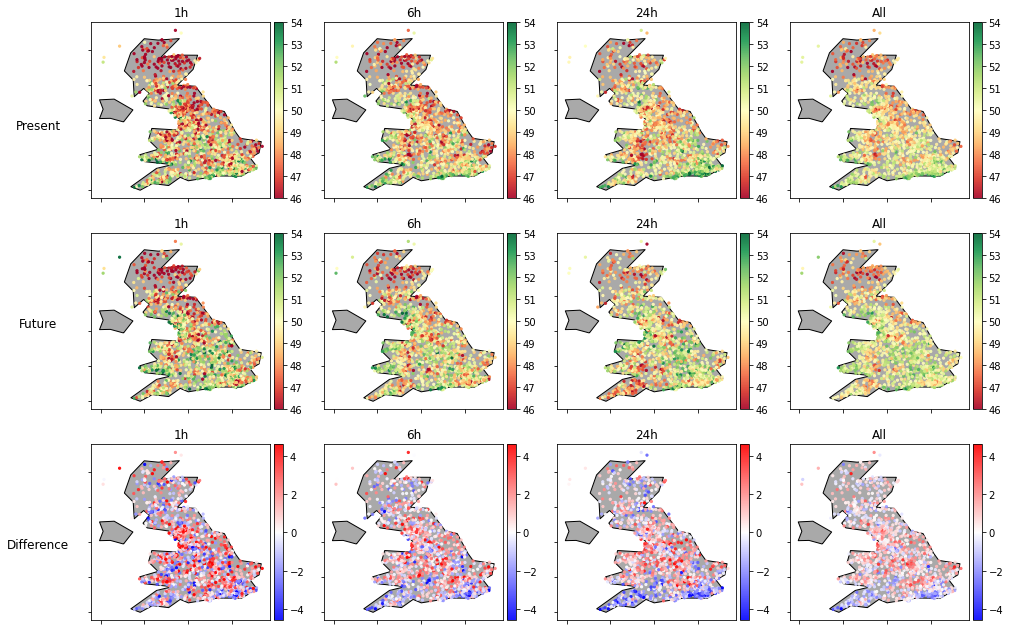

In [12]:
make_plot(df_changes_all, df_changes_byduration, 'D50_mean', 'RdYlGn', 46,54) 

## Distribution of values

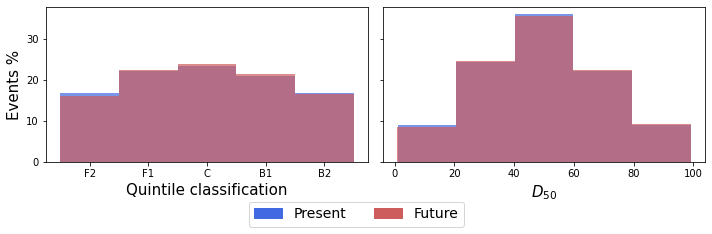

In [13]:
# Assuming present['D50_new'] and future['D50_new'] contain the data
fig, axs = plt.subplots(ncols=2, figsize=(10, 3), sharey=True)

# Calculate the weights for Present and Future to show percentage per bin
present_weights = [100 / len(present['D50_new'])] * len(present['D50_new'])
future_weights = [100 / len(future['D50_new'])] * len(future['D50_new'])

# Histogram for D50 as percentages
axs[1].hist(present['D50_new'], bins=5, alpha=0.7, label='Present', color='royalblue', weights=present_weights)
axs[1].hist(future['D50_new'], bins=5, alpha=0.7, label='Future', color='indianred', weights=future_weights)
axs[1].set_xlabel("$D_{50}$", fontsize=15)
axs[0].set_ylabel('Events %', fontsize=15)
# axs[1].legend(fontsize=12)

# Calculate the weights for Present and Future to show percentage per bin
present_weights = [100 / len(present['max_quintile_molly'])] * len(present['max_quintile_molly'])
future_weights = [100 / len(future['max_quintile_molly'])] * len(future['max_quintile_molly'])

# Calculate bin edges and centers for x-tick positioning
counts, bin_edges = np.histogram(present['max_quintile_molly'], bins=5)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Histogram for D50 as Loading_profile_molly
axs[0].hist(present['max_quintile_molly'], bins=5, alpha=0.7, label='Present', color='royalblue', weights=present_weights)
axs[0].hist(future['max_quintile_molly'], bins=5, alpha=0.7, label='Future', color='indianred', weights=future_weights)
axs[0].set_xlabel('Quintile classification', fontsize=15)
# axs[0].legend(fontsize=12)

# Set x-ticks to bin centers
axs[0].set_xticks(bin_centers)
axs[0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')

fig.legend(handles=[present_patch, future_patch], loc = 'lower center',fontsize=14, ncol=4, bbox_to_anchor=[0.5, -0.1]);

plt.tight_layout()

## Roberto style analysis

In [14]:
# Apply the function to the Age column using the apply() function
present['D50_loading'] = present['D50'].apply(categorise_D50)
future['D50_loading'] = future['D50'].apply(categorise_D50)

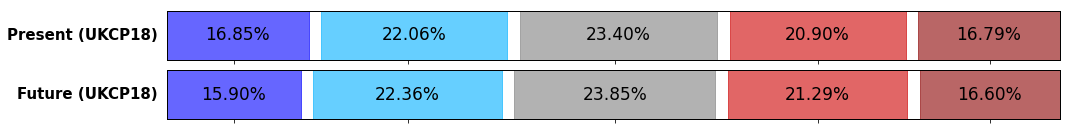

In [15]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future}
short_ids = ['Present (UKCP18)', 'Future (UKCP18)']

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
        quintile_cats, color_mapping,  short_ids[i])

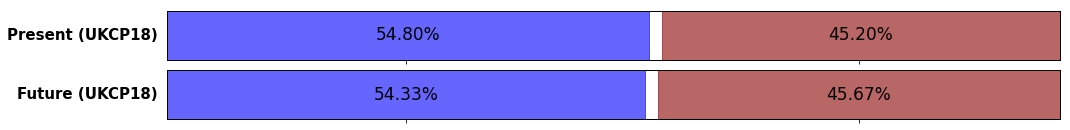

In [16]:
quintile_mapping = {1: 'F', 2: 'B'}
quintile_cats = ['F', 'B']
color_mapping = {'F': (0.0, 0.0, 1.0, 0.6), 'B': (0.5451, 0.0, 0.0, 0.6)}

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'D50_loading', 
        quintile_cats, color_mapping,  short_ids[i])

## Add version for different durations

## Comparing methods

In [17]:
df_long = df_long.sort_values('Loading_profile_molly')
df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

In [ ]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(figsize=(8,4))
plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
plt.show()

### With seasonal split

In [ ]:
# Define custom order for Loading_profile_molly and season
loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# Create a mapping for custom orders
loading_mapping = {value: index for index, value in enumerate(loading_order)}
season_mapping = {value: index for index, value in enumerate(season_order)}

# Add new columns to the DataFrame for sorting
present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
present['Season_order'] = present['season'].map(season_mapping)

# Sort the DataFrame by the new order columns
present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# Drop the temporary sorting columns
present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
fig, axs = plt.subplots(figsize=(12,8))
plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)

### D50 vs Tb0

In [ ]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time', 'Lon', 'Lat']], on='gauge_num', how='left')

## D50 vs Day of year

In [ ]:
df_changes_all_test =df_changes_all.copy()
df_changes_byduration_test = df_changes_byduration.copy()

In [ ]:
# variable = 'D50_P90'
# variable = 'D50_P10'

In [ ]:
durations =[1,6,24]
variable = 'B2_percentage'
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num], this_duration['D_mean_present'],this_duration[f'{variable}_present'], "Day of year", "B2 %", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all_test["D_mean_present"],  df_changes_all_test[f'{variable}_present'],"Day of year", "B2 %", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration[f'{variable}_future'], "Day of year", "B2 %" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3], df_changes_all_test['D_mean_future'], df_changes_all_test[f'{variable}_future'],  "Day of year", "B2 %" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

In [ ]:
durations =[1,6,24]
variable = 'F2_percentage'
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num],this_duration['D_mean_present'], this_duration[f'{variable}_present'],  "Day of year", "F2 %", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all["D_mean_present"], df_changes_all[f'{variable}_present'], "Day of year", "F2 %", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration[f'{variable}_future'],"Day of year", "F2 %" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3],  df_changes_all['D_mean_future'], df_changes_all[f'{variable}_future'], "Day of year", "F2 %" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

In [ ]:
durations =[1,6,24]
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', 'D50_mean_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num], this_duration['D_mean_present'], this_duration['D50_mean_present'], "Day of year", "Mean $D_{50}$", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all['D_mean_present'], df_changes_all['D50_mean_present'],"Day of year", "Mean $D_{50}$", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', 'D50_mean_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration['D50_mean_future'],"Day of year", "Mean $D_{50}$" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3], df_changes_all['D_mean_future'], df_changes_all['D50_mean_future'], "Day of year", "Mean $D_{50}$" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

## Plot contour plot of all events against the day of year they occurred

In [ ]:
# def plot_contour_all_events(ax, data_x, data_y, title, cmap='Blues'):
#     # Create a grid for the contour plot
#     x_grid = np.linspace(data_x.min(), data_x.max(), 100)
#     y_grid = np.linspace(data_y.min(), data_y.max(), 100)
#     X, Y = np.meshgrid(x_grid, y_grid)

#     # Perform Kernel Density Estimation (KDE)
#     kde = gaussian_kde([data_x, data_y])
#     Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

#     # Normalize the density values to be between 0 and 1
#     Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

#     # Create the contour plot with fixed color limits between 0 and 1
#     contour = ax.contourf(X, Y, Z_normalized, levels=10, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
# #     cbar = fig.colorbar(contour, ax=ax)
# #     cbar.set_label('Density (normalized)')

#     # Calculate R^2 and p-value
#     slope, intercept, r_value, p_value, std_err = linregress(data_x, data_y)
#     r_squared = r_value**2

#     # Set labels and title
#     # ax.set_xlabel('%' if ax in [axs[1, 0], axs[1, 1]] else '')
#     ax.set_ylabel("$D_{50}$",fontsize=18)
#     ax.set_xlim(0,366)
#     ax.set_ylim(0,6)

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Present", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Blues' )
axs[1].set_xlabel('Day of Year', fontsize=18);

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

df = future

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Reds' )
axs[1].set_xlabel('Day of Year', fontsize=18);

## Another option: 

In [ ]:
durations =[1,6,24]
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_contour(axes[0, ax_num], this_duration['D'], this_duration['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs" )
plot_contour(axes[0, 3], present['D'], present['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs" )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_contour(axes[1, ax_num], this_duration['D'], this_duration['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs", "Reds" )
plot_contour(axes[1, 3], future['D'], future['D50_new'], "Day of year", "Mean $D_{50}$" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   